# Lynx Motion AL5D

Here is the serial manipulator we are using for our lab. Note all of the dimension at the bottom center.

![](dh_pics/linx_motion_al5d.jpg)

The toy RC servos for the robot arm work off of a pulse width modulation (PWM) where a pulse emmited with the following width will move the servo to a desired position.

| Dir    | PWM  |
|--------|------|
|CCW_max | 1200 |
|Center  | 1500 |
|CW_max  | 1800 |

Since this interface was developed around the 1970's, and toy RC servos are built for price not performance, different servos behave differently to the same signal. Thus, the user typically has to find the true limits of each servo to know how to command it. But the times shown above are approximate (close enough for hand grenades and horseshoes).

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from sympy import symbols, sin, cos, simplify, trigsimp, pi
from math import radians as d2r
from math import degrees as r2d
from math import atan2, sqrt, acos, fabs

In [3]:
class mDH(object):
    """
    This uses the modified DH parameters
    see Craig, eqn (3.6)
    """
    def __init__(self):
        pass

    def fk(self, params):
        t = np.eye(4)
        for p in params:
            t = t.dot(self.makeT(*p))
        return t

    def makeT(self, a, alpha, d, theta):
        return np.array([  # classic DH
            [           cos(theta),           -sin(theta),           0,             a],
            [sin(theta)*cos(alpha), cos(theta)*cos(alpha), -sin(alpha), -d*sin(alpha)],
            [sin(theta)*sin(alpha), cos(theta)*sin(alpha),  cos(alpha),  d*cos(alpha)],
            [                    0,                     0,           0,             1]
        ])

def eval(f):
    """
    This allows you to simplify the trigonomic mess that kinematics can
    create and also substitute in some inputs in the process
    """
    c = []
    for row in f:
        r = []
        for col in row:
            # use python symbolic toolbox to simplify the trig mess above 
            r.append(simplify(col))
        c.append(r)
    return np.array(c)

def subs(f, m):
    """
    This allows you to simplify the trigonomic mess that kinematics can
    create and also substitute in some inputs in the process
    """
    c = []
    for row in f:
        r = []
        for col in row:
            r.append(col.subs(m))
        c.append(r)
    return np.array(c)

def rplot(t1, t2, t3, t4):
    """Given the 4 joint angles (in rads), plot the arm in the x-y and w-z planes"""
    l1 = 5.75
    l2 = 7.375
    l3 = 3.375
    ptsx = [0]
    ptsy = [0]
    
    # our definition is reverse or these joints
    t3 = -t3
    t4 = -t4
    
    # link 1
    x1 = l1*cos(t2)
    y1 = l1*sin(t2)
    ptsx.append(x1)
    ptsy.append(y1)
    
    # link 2
    x2 = x1 + l2*cos(t2 + t3)
    y2 = y1 + l2*sin(t2 + t3)
    ptsx.append(x2)
    ptsy.append(y2)
    
    # link 3
    x3 = x2 + l3*cos(t2 + t3 + t4)
    y3 = y2 + l3*sin(t2 + t3 + t4)
    ptsx.append(x3)
    ptsy.append(y3)
    
    plt.subplot(1,2,1,projection='polar')
    plt.plot([0, t1], [0, 1.0])
    plt.grid(True)
    plt.title('Azimuth Angle (x-y plane)')
    
    plt.subplot(1,2,2)
    plt.plot(ptsx, ptsy, 'b-', marker='o')
    plt.axis('equal')
    plt.grid(True)
    plt.title('w-z Plane')

The DH parameters are:

| i |$a_i$        | $\alpha_i$   | $d_i$   | $theta_i$  |
|---|-------------|--------------|---------|------------|
| 1 | 0           | 0            | $d_2$   | $\theta_1$ |
| 2 | 0           |$\frac{\pi}{2}$| 0       | $\theta_2$ |
| 3 | $a_3$       | 0            | 0       | $\theta_3$ |
| 4 | $a_4$       | 0            | 0       | $\theta_4$ |
| 5 | $a_5$       | 0            | 0       |          0 |

In [4]:
from sympy import pi
t1, t2, t3, t4 = symbols('t1 t2 t3 t4')
# a2, a3, a4, a5 = symbols('a2 a3 a4 a5')

# t1 - base
# t2 - shoulder
# t3 - elbow
# t4 - wrist

# a2 = 2.75   # base to shoulder
a2 = 0.0
a3 = 5.75   # shoulder to elbow
a4 = 7.375  # elbow to wrist
a5 = 3.375  # wrist to end effector

# put all angles in rads
# sybolic can't handle converting a symbol using d2r()
# a, alpha, d, theta
params = [
    [    0,    0,    0, t1],
    [    a3, -pi/2,   0, t2],
    [   a4,    0,    0, t3],
    [   a5,    0,    0, t4]
]
# params = [
#     [       0,    0, 2.75, t1],
#     [       0, pi/2,    0, t2],
#     [    5.75,    0,    0, t3],
#     [   7.375,    0,    0, t4],
#     [   3.375,    0,    0,  0]
# ]
dh = mDH()
al5d = dh.fk(params)
al5d = eval(al5d)

In [5]:
def printT(tt):
    """Print out the entire T matrix"""
    R = tt[0:3,0:3]
    D = tt[0:3, 3]
    print('-'*30)
    print('Position:')
    print('  x:', D[0])
    print('  y:', D[1])
    print('  z:', D[2])
    # R(n, o, a)
    print('-'*30)
    print('Orientation')
    print('  nx:', R[0,0])
    print('  ny:', R[0,1])
    print('  nz:', R[0,2])
    print('')
    print('  ox:', R[1,0])
    print('  oy:', R[1,1])
    print('  oz:', R[1,2])
    print('')
    print('  ax:', R[2,0])
    print('  ay:', R[2,1])
    print('  az:', R[2,2])

def printP(dh):
    """dh is the forward kinematics equations matrix"""
    pos = [float(x) for x in dh[0:3, 3]]
    print('Pos (x,y,z): {:5.2f} {:5.2f} {:5.2f}'.format(*pos))
    return pos

def printDegrees(angles):
    """angles are in radians"""
    a = [r2d(x) for x in angles]
    print('Angles: {:6.1f} {:6.1f} {:6.1f} {:6.1f}'.format(*a))

In [6]:
# the symbolic forward kinematics of our robot arm
printT(al5d)

------------------------------
Position:
  x: (7.375*cos(t2) + 3.375*cos(t2 + t3) + 5.75)*cos(t1)
  y: (7.375*cos(t2) + 3.375*cos(t2 + t3) + 5.75)*sin(t1)
  z: -7.375*sin(t2) - 3.375*sin(t2 + t3)
------------------------------
Orientation
  nx: 1.0*cos(t1)*cos(t2 + t3 + t4)
  ny: -1.0*sin(t2 + t3 + t4)*cos(t1)
  nz: -1.0*sin(t1)

  ox: 1.0*sin(t1)*cos(t2 + t3 + t4)
  oy: -1.0*sin(t1)*sin(t2 + t3 + t4)
  oz: 1.0*cos(t1)

  ax: -1.0*sin(t2 + t3 + t4)
  ay: -1.0*cos(t2 + t3 + t4)
  az: 0


In [7]:
# Let's set some angles
simp=subs(al5d, [(t1,0.0), (t2,pi/2), (t3, pi/2), (t4, 0.0)])
printT(simp)

------------------------------
Position:
  x: 2.37500000000000
  y: 0
  z: -7.37500000000000
------------------------------
Orientation
  nx: -1.00000000000000
  ny: 0
  nz: 0

  ox: 0
  oy: 0
  oz: 1.00000000000000

  ax: 0
  ay: 1.00000000000000
  az: 0


In [9]:
simp=subs(al5d, [(t1,0.0),(t2,d2r(111.5)), (t3, d2r(-127)), (t4, d2r(-74.5))])
printP(simp)

Pos (x,y,z):  5.00  0.00  0.00


[4.999392538748885, 0.0, 0.004017992319495178]

# Inverse Kinematics

![](http://mathworld.wolfram.com/images/eps-gif/LawofCosines_1000.gif)

## Law of Cosines

$$
a^2 = b^2 + c^2 - 2bc \cos(A) \rightarrow \cos(A)=\frac{-a^2+b^2+c^2}{2bc}\\
b^2 = a^2 + c^2 - 2ac \cos(B) \rightarrow \cos(B)=\frac{a^2-b^2+c^2}{2ac}\\
c^2 = a^2 + b^2 - 2ab \cos(C) \rightarrow \cos(C)=\frac{a^2+b^2-c^2}{2ab}
$$

- [Wolfram: law of cosines](http://mathworld.wolfram.com/LawofCosines.html)

## Law of Sines

$$
\frac{a}{\sin(A)} = \frac{b}{\sin(B)} = \frac{c}{\sin(C)}
$$

- [Wolfram: law of sines](http://mathworld.wolfram.com/LawofSines.html)

## Arm

We are going to solve this using geometry! So, given a point (w,z) and the
orientation of the end effector, we will calculate the joint angles ($\theta_2$,
$\theta_3$, $\theta_4$).

![](dh_pics/robot_arm.png)

You will also want to make some checks:

- $z \geq 0$
- $-1 \geq \arctan(\frac{y}{x}) \leq 1$
- $\|(x,y,z) \| \leq \|(l_1, l_2, l_3) \|$

In [10]:
from math import atan2, acos, sqrt, pi, cos, sin

In [11]:
def cosine_law(a, b, c, phase=False):
    if phase:
        angle = ((c**2 - (a**2 + b**2))/(2*a*b))
    else:
        angle = ((c**2 - (a**2 + b**2))/(-2*a*b))
    
#     print('cosine_law', angle)
        
    if angle > 1 or angle < -1:
        raise Exception('angle outside range')
    return acos(angle)


def line(x1, y1, x2, y2):
    return sqrt((x2-x1)**2 + (y2-y1)**2)


def mag(a, b):
    return sqrt(a**2 + b**2)

def mag3(a, b, c):
    return sqrt(a**2 + b**2 + c**2)

In [12]:
def inverse(x, y, z, orient):
    """
    Azimuth angle is between x and w and lies in the x-y plane
    
               ^ x
         w     |
           \   |
            \  |
             \ |
              \|
    <----------+ (z is out of the page - right hand rule)
    y
    
    Most of the robot arm move in the plane defined by w-z
    
    ^ z
    |   o-----o
    |  /       \
    | /         E
    |/
    +----------------> w
    
    All joint angles returned are in radians: (t1, t2, t3, t4)
    
    """
    l1 = 5.75
    l2 = 7.375
    l3 = 3.375

    # check workspace constraints
    if z < 0:
        raise Exception('z in ground')
    elif mag3(x,y,z) > (l1 + l2 + l3):
        raise Exception('out of reach')
    
    # get x-y plane azimuth
    t1 = atan2(y, x)
    
    # Now, most of the arm operates in the w-z frame
    w = mag(x, y)         # new frame axis
    gamma = atan2(z, w)
    r = mag(z, w)
    
    c = mag(w-l3*cos(orient), z-l3*sin(orient))

    t3 = cosine_law(l1, l2, c, True)
    
    d = cosine_law(l2, c, l1)
    e = cosine_law(c, l3, r)
    t4 = pi - d - e
    
    alpha = cosine_law(l1, c, l2)
    beta = cosine_law(c,r,l3)

    t2 = alpha + beta + gamma

    return (t1, t2, t3, t4)

In [13]:
def checkPts(x, y, z, orient):
    """Given a point (in inches) and orientation (in rads), this calculates
    the joint angles, then uses those angles to calculate the forward solution
    and prints out the error. It also plots the arm.
    """
    angles = inverse(x, y, z, orient)
    
    a,b,c,d = angles

    simp=subs(al5d, [(t1, a), (t2, b), (t3, -c), (t4, -d)])
    pts = printP(simp)

    printDegrees(angles)
    rplot(*angles)
    
    error = [a-b for a,b in zip((x,y,z), pts)]
    print('Error: {:6.3f} {:6.3f} {:6.3f}'.format(*error))

Pos (x,y,z): 10.75  0.00  5.75
Angles:    0.0   90.0   90.0   -0.0
Error:  0.000  0.000 -0.000


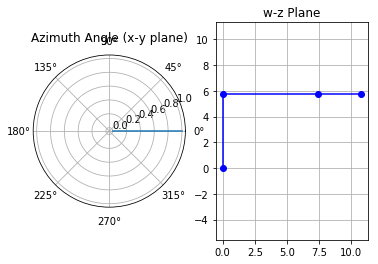

In [14]:
checkPts(10.75, 0, 5.75, 0.0)

Angles:    0.0    1.6    1.6    1.6
Pos (x,y,z):  7.38  0.00  2.38
Angles:    0.0   89.9   89.9   90.0
Error:  0.000  0.000 -0.000


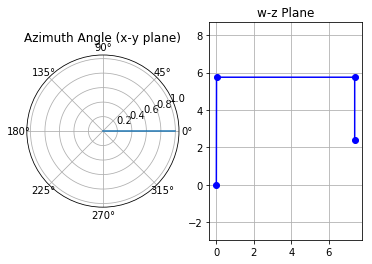

In [164]:
# 0 90 -90 0
checkPts(7.385, 0, 5.75-3.375, -pi/2)

Angles:    0.8    1.6    1.6    1.6
Pos (x,y,z):  5.22  5.22  2.38
Angles:   45.0   89.9   89.9   90.0
Error:  0.000  0.000 -0.000


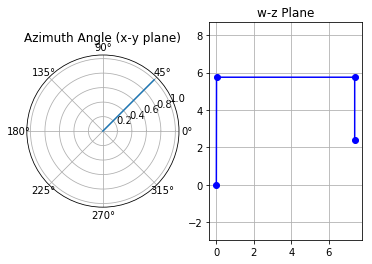

In [163]:
x,y,z = (7.385*cos(pi/4), 7.385*sin(pi/4), 5.75-3.375)
checkPts(x,y,z, -pi/2)

Angles:   -0.8    1.6    1.6    1.6
Pos (x,y,z):  5.22 -5.22  2.38
Angles:  -45.0   89.9   89.9   90.0
Error:  0.000  0.000 -0.000


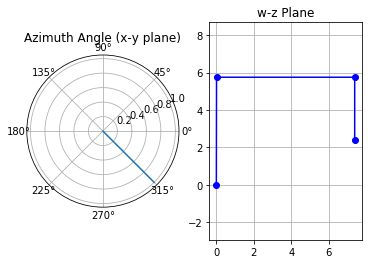

In [162]:
x,y,z = (7.385*cos(-pi/4), 7.385*sin(-pi/4), 5.75-3.375)
checkPts(x,y,z, -pi/2)

Angles:    1.6    1.6    1.6    1.6
Pos (x,y,z):  0.00  7.38  2.38
Angles:   90.0   89.9   89.9   90.0
Error:  0.000  0.000 -0.000


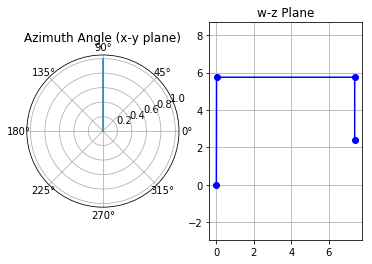

In [161]:
x,y,z = (7.385*cos(pi/2), 7.385*sin(pi/2), 5.75-3.375)
checkPts(x,y,z, -pi/2)

Angles:    0.0    1.9    2.2    1.3
Pos (x,y,z):  5.00  0.00  0.00
Angles:    0.0  111.5  127.0   74.5
Error: -0.000  0.000  0.000


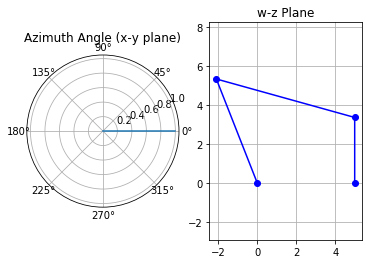

In [171]:
checkPts(5,0,0, -pi/2)

Angles:   -0.4    1.5    1.8    1.2
Pos (x,y,z):  7.00 -3.00  0.00
Angles:  -23.2   83.8  102.3   71.5
Error: -0.000  0.000 -0.000


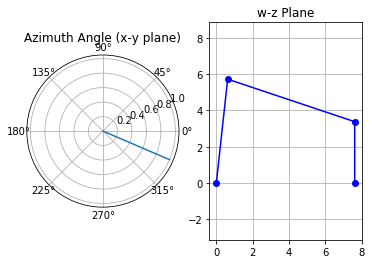

In [159]:
checkPts(7,-3,0, -pi/2)

Angles:    0.7    1.2    0.9    1.9
Pos (x,y,z):  7.00  6.00  4.00
Angles:   40.6   68.3   52.2  106.0
Error: -0.000 -0.000  0.000


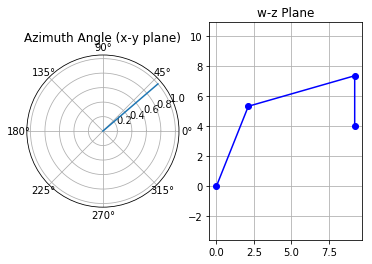

In [158]:
checkPts(7,6,4, -pi/2)

# Phasing

Let's show $\cos(\pi-\theta)$ and $\cos(\theta - \pi)$ are the same thing.

In [16]:
print(cos(pi-1))
print(cos(1-pi))
print(cos(1))

-0.540302305868
-0.540302305868
0.540302305868


In [40]:
# let's plot cos from -pi to pi
def draw(p, title):
    test = []
    for i in range(-pi*100, pi*100):
        if p == pi:
            ans = cos(pi - i/100)
        elif p == -pi:
            ans = cos(i/100 - pi)
        else:
            ans = cos(i/100)
        test.append(ans)
    x = [x/100 for x in range(-pi*100, pi*100)]
    plt.plot(x,test)
    plt.title(title)
    plt.grid(True)

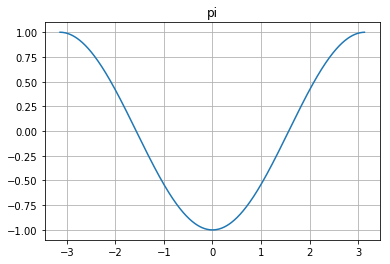

In [37]:
draw(pi, 'pi')

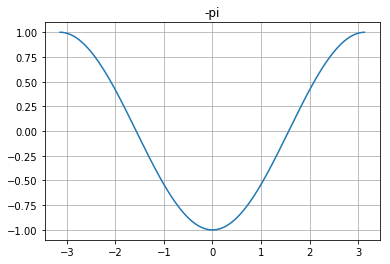

In [38]:
draw(-pi, '-pi')

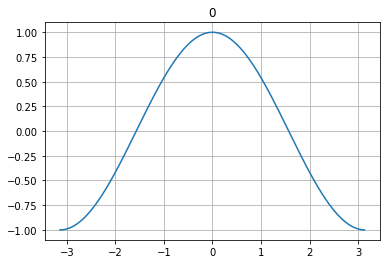

In [39]:
draw(0, '0')